# Algorithmic Fairness, Accountability, and Ethics, Spring 2023

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

pd.set_option("display.max_columns", None)  # display all columns

rs = 19  # random state for reproducibility

In [2]:
def data_processing(
    df: pd.DataFrame, features: list[str], target_name: str, threshold: float = 35000
) -> pd.DataFrame:
    """Function that preprocesses the dataset

    Args:
        df (pd.DataFrame): the raw data set
        features (list[str]): the features we are interested in
        target_name (str): the target variable
        threshold (float, optional): A user defined threshold that we want to analyse the target variable by. Defaults to 35000.

    Returns:
        pd.DataFrame: the preprocessed data
    """
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df["AGEP"] > 16]
    df = df[df["PINCP"] > 100]
    df = df[df["WKHP"] > 0]  # Usual hours worked per week last year
    df = df[df["PWGTP"] >= 1]  # don't know what this is
    ### Adult Filter (ENDS)

    ### Groups of interest
    sex = df["SEX"].values

    ### Target
    df["target"] = (
        df[target_name] > threshold
    )  # add a column indicating whether a person has the target or not (earning more than the provided threshold)
    target = df["target"].values

    df = df[features + ["target", target_name]]
    df_processed = df[
        features
    ].copy()  # we want to keep df before one_hot encoding to make Bias Analysis

    cols = [
        "HINS1",
        "HINS2",
        "HINS4",
        "CIT",
        "COW",
        "SCHL",
        "MAR",
        "SEX",
        "RAC1P",
    ]  # the columns we one-hot encode

    df_processed = pd.get_dummies(  # one-hot encoding
        df_processed,
        prefix=None,
        prefix_sep="_",
        dummy_na=False, # dont add a column for missing values
        columns=cols,  # the columns we create the dummies for
        drop_first=True,
    )
    df_processed = pd.get_dummies(
        df_processed,
        prefix=None,
        prefix_sep="_",
        dummy_na=True,  # add a column for missing values
        columns=["ENG"],
        drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
    )
    return df_processed, df, target, sex

In [3]:
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["CA"], download=True)  # the raw data

# the features we are investigating:
feature_names = [
    "AGEP",  # Age
    "CIT",  # Citizenship status
    "COW",  # Class of worker
    "ENG",  # Ability to speak English
    "SCHL",  # Educational attainment
    "MAR",  # Marital status
    "HINS1",  # Insurance through a current or former employer or union
    "HINS2",  # Insurance purchased directly from an insurance company
    "HINS4",  # Medicaid
    "RAC1P",  # Recoded detailed race code
    "SEX",
]

data, data_original, target, group = data_processing(
    df=acs_data, features=feature_names, target_name="PINCP", threshold=35_000
)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0
)

,AGEP,CIT,COW,ENG,SCHL,MAR,HINS1,HINS2,HINS4,RAC1P,SEX,target,PINCP
0,30,1,6.0,1.0,14.0,1,2,2,1,8,1,True,48500.0
6,21,1,4.0,NaN,16.0,5,2,1,2,1,1,False,7700.0
7,65,1,2.0,1.0,22.0,5,2,2,2,1,1,False,17200.0
10,33,1,1.0,1.0,14.0,3,2,2,1,1,1,False,12000.0
13,18,1,2.0,NaN,19.0,5,2,1,2,1,2,False,300.0


,AGEP,CIT,COW,ENG,SCHL,MAR,HINS1,HINS2,HINS4,RAC1P,SEX,PINCP
count,195665.000000,195665.000000,195665.000000,82587.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,195665.000000,1.956650e+05
mean,42.734914,2.100253,2.144083,1.609539,18.470309,2.654343,1.348913,1.865377,1.856689,3.072675,1.472001,6.519205e+04
std,14.884622,1.612849,1.887825,0.881782,3.942463,1.846382,0.476628,0.341321,0.350391,2.915503,0.499217,8.580121e+04
min,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.100000e+02
25%,30.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000e+04
50%,42.000000,1.000000,1.000000,1.000000,19.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,4.000000e+04
75%,55.000000,4.000000,3.000000,2.000000,21.000000,5.000000,2.000000,2.000000,2.000000,6.000000,2.000000,8.000000e+04
max,94.000000,5.000000,8.000000,4.000000,24.000000,5.000000,2.000000,2.000000,2.000000,9.000000,2.000000,1.325300e+06


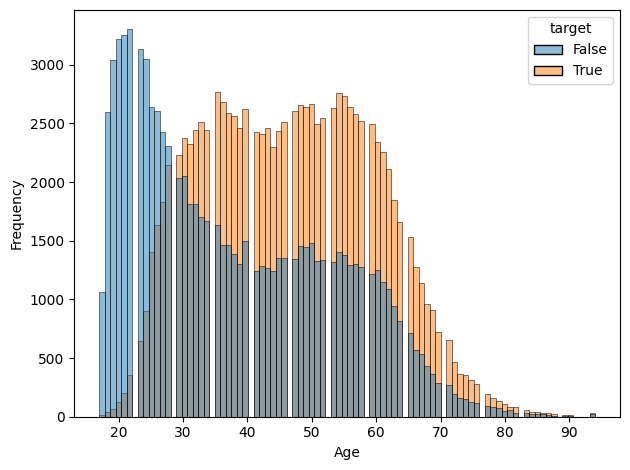

In [42]:
# Data Exploration
display(data_original.head())
display(data_original.describe())

fig = sns.histplot(data_original, x="AGEP", hue="target")
fig.set_xlabel('Age')
fig.set_ylabel('Frequency')

plt.tight_layout()

# Task 1

1) Starting from the template, train two different classifiers on the training data: a white-box model (use logistic regression or a decision tree), and a black-box model (use a random forest, a gradient-boosted decision tree, an SVM, or a Neural Network). Consider feature engineering and scaling steps necessary for some of these classifiers and summarize the necessary changes in your report. For the white-box model, focus on parameter choices that will later allow you to interpret the results of the model. For both models, report on the accuracy of the classifier on the test set.


For the white box model we are using a Decision Tree Classifier.
We are aiming to not make the tree to large, as this will cloud interpretability

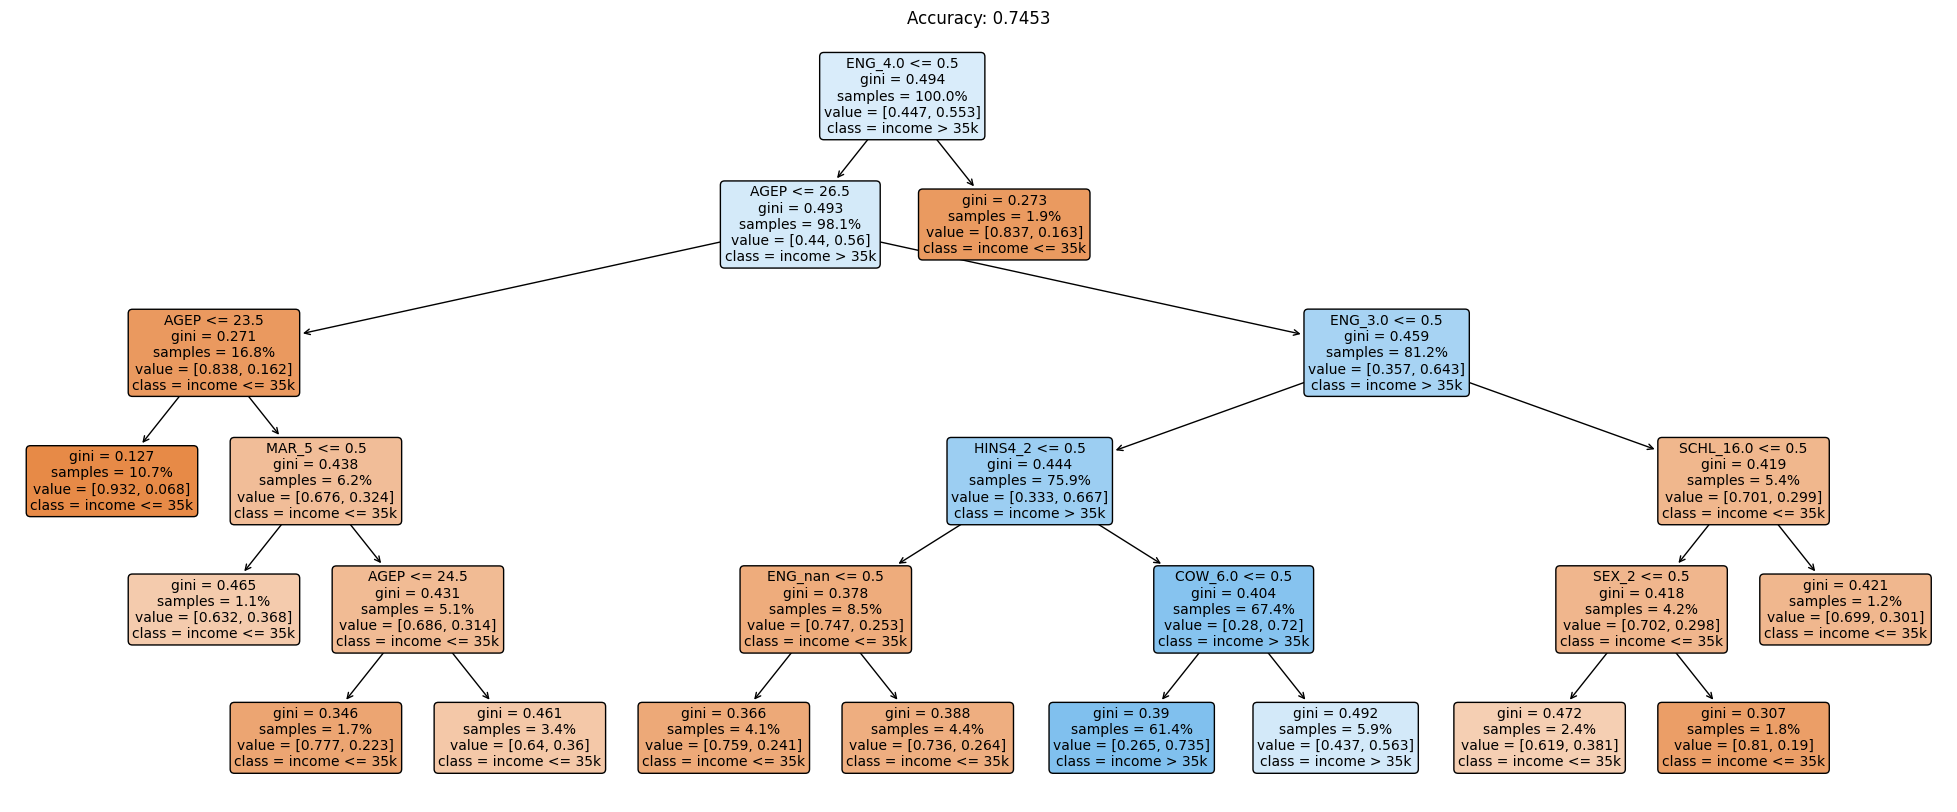

In [58]:
# white box models - Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    min_samples_split=0.01, # the fraction of minimum number of samples required to split an internal node
    min_samples_leaf=0.01, # the fraction of minimum number of samples required to be at a leaf node
    max_features="sqrt", # sqrt(n_features). Number of featuers to consider when looking for the best split
    max_depth=5, # sweet spot
    criterion="gini", # function to measure the quality of a split. 
    random_state=rs,
)

dt_classifier.fit(X_train, y_train)

fig = plt.figure(figsize=(25, 10))
nodes = plot_tree(
    decision_tree=dt_classifier,
    feature_names=X_train.columns,
    class_names=["income <= 35k", "income > 35k"],
    fontsize=10,
    filled=True,
    rounded=True,
    proportion=True,
)
plt.title(f"Accuracy: {round(accuracy_score(y_test, dt_classifier.predict(X_test)),4)}")
plt.show()

In [ ]:
# white box model - Logistic 
lr_classifier = LogisticRegression(
    penalty="l2",
    
)

In [89]:
# black box models - Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, # number of trees
    criterion="gini",
    max_features="sqrt",
    max_depth=None,
    min_samples_split=0.005,
    min_samples_leaf=0.005,
    random_state=rs,
)

rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {round(accuracy, 4)}")

Accuracy: 0.7702
